# Predicting regional fire sizes from given frequency locations 

Authors: Jatan Buch (v1, 220118) || (v2, 220303)

## Loading packages and data products

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
#from time import clock
from datetime import date, datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm
from copy import deepcopy

#Import and write files
import csv
import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *

#Helper functions
from math import factorial
from scipy import stats
from scipy.special import gamma
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
from tensorflow.python import ops
from tensorflow.python import debug as tf_debug

#Plot modules
import matplotlib.pyplot as plt
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

#Stats modules
from scipy import stats
from scipy.stats import norm, pareto, genpareto
import statsmodels.api as sm
from scipy import stats, interpolate
from scipy.optimize import minimize

# Data processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#modules for Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

#modules for Neural Network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

In [2]:
def sampling_func(size_arr):

    s= pd.Series(size_arr)
    s= s[~s.duplicated()]
    
    empcdf_sizes= tfd.Empirical(s) 
    cdf_emp_sizes= empcdf_sizes.cdf(s)
    kde_density= stats.gaussian_kde(size_arr, bw_method= "silverman")
    curve_1= 1 - np.sort(cdf_emp_sizes)
    curve_2= kde_density.evaluate(np.sort(s))[1:]
    curve_1= curve_1[curve_1!= 0]

    eff_curve= 10**(0.5*(np.log10(curve_1) + np.log10(curve_2)))
    eff_curve_func= interpolate.interp1d(np.sort(s)[1:], eff_curve, kind= 'linear', fill_value= 'extrapolate')
    
    return eff_curve_func

## Data preprocessing

In [3]:
data_dir= "../data/"
fire_file= data_dir + "burnarea_12km.nc"
clim_df= pd.read_hdf('../data/clim_fire_freq_12km_data.h5')
clim_df.loc[clim_df[clim_df.fire_freq > 1].index, 'fire_freq']= np.ones(len(clim_df[clim_df.fire_freq > 1].index), dtype= np.int64) #sets all non-zero frequencies to 1
#clim_df= clim_df[clim_df.reg_indx != 0].reset_index().drop(columns= ['index']) #needs to match the config in ml_grid_model to ensure proper indexing for freq locations

In [4]:
n_features= 36
start_month= 420
tot_test_months= 12
end_month= start_month + tot_test_months

In [25]:
X_sizes_train, X_sizes_val, y_sizes_train, y_sizes_val, fire_size_train, fire_size_test, X_sizes_test, y_sizes_test= fire_size_data(res= '12km', \
                                                dropcols= ['CAPE', 'Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'FFWI_max7', 'Avgprec_4mo', 'Avgprec_2mo', \
                                                'AvgVPD_4mo', 'AvgVPD_2mo', 'Tmax_max7', 'VPD_max7', 'Tmin_max7'], start_month= start_month, tot_test_months= tot_test_months, scaled= True) #size_scaler

X_sizes_train_df= pd.concat([X_sizes_train, X_sizes_val], sort= False).reset_index().drop(columns=['index'])
X_sizes_tot= pd.concat([X_sizes_train_df, X_sizes_test], sort= False).reset_index().drop(columns=['index'])
fire_size_tot= pd.concat([fire_size_train, fire_size_test], sort= False).reset_index().drop(columns=['index'])

fire_size_arr= np.concatenate([y_sizes_train, y_sizes_val]) #, y_sizes_test
#empcdf_sizes= tfd.Empirical(np.sort(fire_size_arr)) 
#kde_density= stats.gaussian_kde(fire_size_arr, bw_method= "silverman")
eff_freq_func= sampling_func(y_sizes_train)
norm_fac= 1e-5
samp_weight_arr= norm_fac/eff_freq_func(y_sizes_train)  #empcdf_sizes.cdf(y_sizes_train) #kde_density.evaluate(y_sizes_train) eff_freq_func(y_sizes_train)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 345/345 [00:00<00:00, 1172.63it/s]


In [6]:
# fire_freq_test_df= clim_df[(clim_df.month >= start_month) & (clim_df.month < end_month)]
# fire_freq_train_df= clim_df.drop(fire_freq_test_df.index)

# tmp_freq_df= clim_df[clim_df.iloc[:, 0:n_features].columns]
# X_freq_df= pd.DataFrame({})
# scaler= StandardScaler().fit(fire_freq_train_df.iloc[:, 0:n_features])
# X_freq_df[tmp_freq_df.columns]= scaler.transform(tmp_freq_df) #size_scaler

In [7]:
# X_train_tot= X_freq_df.iloc[fire_freq_train_df.index]
# X_train_tot.loc[:, 'reg_indx']= fire_freq_train_df.reg_indx
# X_train_tot.loc[:, 'month']= fire_freq_train_df.month
# X_train_tot= X_train_tot.reset_index().drop(columns=['index', 'Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'FFWI_max7', 'Avgprec_4mo', 'Avgprec_2mo', \
#                                                                                                 'AvgVPD_4mo', 'AvgVPD_2mo', 'Tmax_max7', 'VPD_max7', 'Tmin_max7'])
# X_test_df= X_freq_df.iloc[fire_freq_test_df.index]
# X_test_df.loc[:, 'reg_indx']= fire_freq_test_df.reg_indx
# X_test_df.loc[:, 'month']= fire_freq_test_df.month
# X_test_df= X_test_df.reset_index().drop(columns=['index', 'Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'FFWI_max7', 'Avgprec_4mo', 'Avgprec_2mo', \
#                                                                                                 'AvgVPD_4mo', 'AvgVPD_2mo', 'Tmax_max7', 'VPD_max7', 'Tmin_max7'])

# X_test_tot= pd.concat([X_train_tot, X_test_df], sort= False).reset_index().drop(columns=['index'])
# fire_freq_tot= pd.concat([fire_freq_train_df, fire_freq_test_df], sort= False).reset_index().drop(columns=['index'])

## MDN grid scale fire size

### Loading saved fire frequency models

In [6]:
run_id, it, bs, p_frac= ['02_27_22', 2, 8192, '0.3'] #['03_01_22', 12, 8192, '0.3'] #['02_27_22', 2, 8192, '0.3']
freq_loc_df= pd.read_hdf('../sav_files/freq_loc_df_%s'%run_id + '_%s'%bs + '_pfrac_%s'%str(p_frac) + '_iter_run_%d.h5'%it)

In [7]:
mdn_freq_df= pd.read_hdf('../sav_files/mdn_mon_fire_freq_02_27_22_it_2_8192_0.3.h5')
mdn_mon_freq_df, mdn_ann_freq_df= calib_freq_predict(ml_freq_df= mdn_freq_df, n_regs= 18, tot_months= 432, test_start= 372, test_tot= 60, ml_model= 'mdn')
mdn_mon_freq_groups= mdn_mon_freq_df.groupby('reg_indx')
mdn_ann_freq_groups= mdn_ann_freq_df.groupby('reg_indx')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 27.65it/s]


### Setting up fire size models

In [8]:
nregions= 18
max_fire_train_arr= []
sum_fire_train_arr= []

for r in tqdm(range(nregions)):
    max_fire_train_arr.append(np.max(np.concatenate([fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').get_group(k).fire_size.to_numpy()/1e6 \
                                    for k in fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').groups.keys()])))
    sum_fire_train_arr.append(np.max([np.sum(fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').get_group(k).fire_size.to_numpy()/1e6) \
                                    for k in fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').groups.keys()]))
    
max_fire_train_arr= np.asarray(max_fire_train_arr)
sum_fire_train_arr= np.asarray(sum_fire_train_arr)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.97it/s]


In [26]:
%time mdn_gpd_size_model, _= reg_fire_size_func(X_train_dat= X_sizes_train, y_train_dat= y_sizes_train, X_val_dat= X_sizes_val, y_val_dat= y_sizes_val, \
                            size_test_df= fire_size_test, X_test_dat= X_sizes_test, max_size_arr= max_fire_train_arr, sum_size_arr= sum_fire_train_arr, \
                            epochs= 500, bs= 32, func_flag= 'gpd', lnc_arr= [1, 16, 4], samp_weights= True, samp_weight_arr= samp_weight_arr, loco= True, rseed= 87) #

Initialized a MDN with 1 layers and 16 neurons
MDN trained for 75 epochs
CPU times: user 18.5 s, sys: 2.29 s, total: 20.8 s
Wall time: 15.5 s


In [12]:
%time mdn_lognorm_size_model, _= reg_fire_size_func(X_train_dat= X_sizes_train, y_train_dat= y_sizes_train, X_val_dat= X_sizes_val, y_val_dat= y_sizes_val, \
                            size_test_df= fire_size_test, X_test_dat= X_sizes_test, max_size_arr= max_fire_train_arr, sum_size_arr= sum_fire_train_arr, \
                            epochs= 500, bs= 32, func_flag= 'lognorm', lnc_arr= [2, 8, 2], samp_weights= True, samp_weight_arr= samp_weight_arr, loco= True, rseed= 87)

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 370 epochs
CPU times: user 1min 26s, sys: 8.45 s, total: 1min 35s
Wall time: 1min 12s


In [13]:
%time mdn_lognorm_gpd_size_model, _= reg_fire_size_func(X_train_dat= X_sizes_train, y_train_dat= y_sizes_train, X_val_dat= X_sizes_val, y_val_dat= y_sizes_val, \
                            size_test_df= fire_size_test, X_test_dat= X_sizes_test, max_size_arr= max_fire_train_arr, sum_size_arr= sum_fire_train_arr, \
                            epochs= 500, bs= 32, func_flag= 'lognorm_gpd', lnc_arr= [2, 8, 2], samp_weights= True, samp_weight_arr= samp_weight_arr, loco= True, rseed= 87)

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 204 epochs
CPU times: user 56.1 s, sys: 4.68 s, total: 1min
Wall time: 48.3 s


In [27]:
reg_gpd_data_size_df= grid_size_pred_func(mdn_model= mdn_gpd_size_model, stat_model= gpd_model, max_size_arr= max_fire_train_arr, sum_size_arr= sum_fire_train_arr, \
                                    start_month= 0, freq_flag= 'data', size_test_df= fire_size_tot, X_size_test_dat= X_sizes_tot, \
                                    debug= False, seed= 99) #lognorm_gpd_model_predict
reg_gpd_data_size_groups= reg_gpd_data_size_df.groupby('reg_indx')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:54<00:00,  3.05s/it]


In [15]:
reg_lognorm_gpd_data_size_df= grid_size_pred_func(mdn_model= mdn_lognorm_gpd_size_model, stat_model= lognorm_gpd_model_predict, max_size_arr= max_fire_train_arr, sum_size_arr= sum_fire_train_arr, \
                                    start_month= 0, freq_flag= 'data', size_test_df= fire_size_tot, X_size_test_dat= X_sizes_tot, \
                                    debug= False, seed= 99) #lognorm_gpd_model_predict
reg_lognorm_gpd_data_size_groups= reg_lognorm_gpd_data_size_df.groupby('reg_indx')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [01:00<00:00,  3.35s/it]


In [16]:
reg_lognorm_data_size_df= grid_size_pred_func(mdn_model= mdn_lognorm_size_model, stat_model= lognorm_model, max_size_arr= max_fire_train_arr, sum_size_arr= sum_fire_train_arr, \
                                    start_month= 0, freq_flag= 'data', size_test_df= fire_size_tot, X_size_test_dat= X_sizes_tot, \
                                    debug= False, seed= 99) #lognorm_gpd_model_predict
reg_lognorm_data_size_groups= reg_lognorm_data_size_df.groupby('reg_indx')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:54<00:00,  3.02s/it]


In [19]:
# reg_ml_gpd_size_df= grid_size_pred_func(mdn_model= mdn_gpd_size_model, stat_model= gpd_model, max_size_arr= max_fire_train_arr, sum_size_arr= sum_fire_train_arr, \
#                                     start_month= 0, freq_flag= 'ml', loc_df= freq_loc_df, ml_freq_df= mdn_mon_freq_df, X_freq_test_dat= X_test_tot, \
#                                     debug= False, seed= 99)
# reg_ml_gpd_size_groups= reg_ml_gpd_size_df.groupby('reg_indx')

In [29]:
size_id= '04_05_22'
freq_id= '02_27_22'

mdn_gpd_size_model.save('../sav_files/mdn_gpd_size_model_%s'%size_id)
mdn_lognorm_gpd_size_model.save('../sav_files/mdn_lognorm_gpd_size_model_%s'%size_id)
mdn_lognorm_size_model.save('../sav_files/mdn_lognorm_size_model_%s'%size_id)

#reg_ml_gpd_size_df.to_hdf('../sav_files/gpd_mon_fire_size_%s'%size_id + '_ml_freq_run_%s'%freq_id + '_df.h5', key= 'df', mode= 'w')
#reg_ml_lognorm_gpd_size_df.to_hdf('../sav_files/lognorm_gpd_mon_fire_size_%s'%size_id + '_ml_freq_run_%s'%freq_id + '_df.h5', key= 'df', mode= 'w')
reg_gpd_data_size_df.to_hdf('../sav_files/gpd_mon_fire_size_%s'%size_id + '_data_freq_df.h5', key= 'df', mode= 'w')
reg_lognorm_gpd_data_size_df.to_hdf('../sav_files/lognorm_gpd_mon_fire_size_%s'%size_id + '_data_freq_df.h5', key= 'df', mode= 'w')
reg_lognorm_data_size_df.to_hdf('../sav_files/lognorm_mon_fire_size_%s'%size_id + '_data_freq_df.h5', key= 'df', mode= 'w')

INFO:tensorflow:Assets written to: ../sav_files/mdn_gpd_size_model_04_05_22/assets


In [21]:
tot_months= 432

#month_arr= np.linspace(start_month, final_month - 1, tot_months, dtype= np.int64)
month_arr= np.linspace(0, tot_months - 1, tot_months, dtype= np.int64)
year_arr=  np.arange(1984, 2021, 4) #np.asarray([2015, 2016, 2017, 2018, 2019, 2020]) 
yr_arr= np.arange(0, tot_months + 1, 12) 
ind_grid_1= [[1, 2, 6], [7, 8, 9]]
ind_grid_2= [[11, 12, 17], [13, 14, 16]]

reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", \
          15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}

In [22]:
size_id= '03_13_22'
freq_id= '02_27_22'

reg_data_size_alt_df= pd.read_hdf('../sav_files/gpd_mon_fire_size_%s'%size_id + '_data_freq_df.h5')
reg_data_size_alt_groups= reg_data_size_alt_df.groupby('reg_indx')

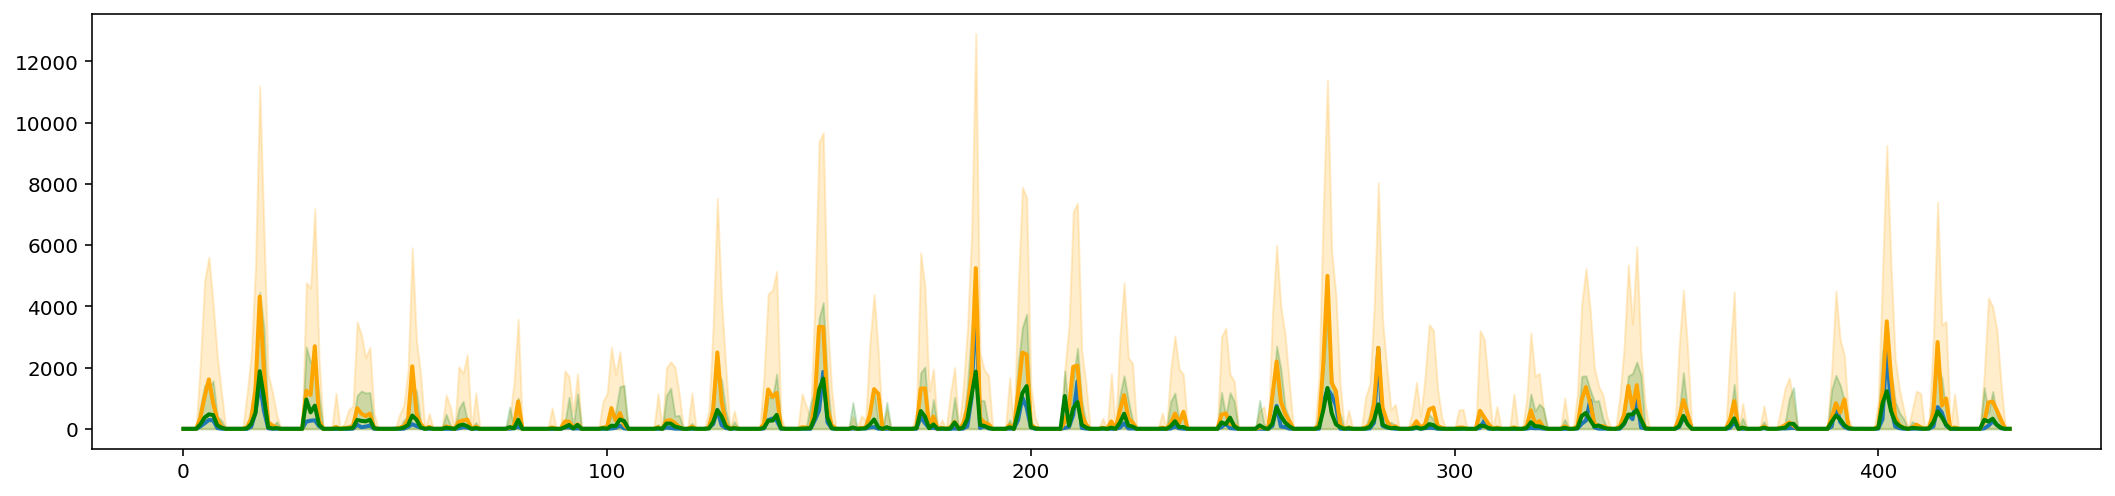

In [28]:
fig, ax= plt.subplots(1, 1, figsize=(18, 4))
regindx= 13

plt.plot(month_arr, mon_burned_area(fire_file, regindx), lw= 2, label= 'Observed')
plt.plot(month_arr, reg_gpd_data_size_groups.get_group(regindx)['mean_size'], color= 'orange', lw= 2, label= 'Predicted');
plt.fill_between(month_arr, reg_gpd_data_size_groups.get_group(regindx)['high_1sig_size'], reg_gpd_data_size_groups.get_group(regindx)['low_1sig_size'], \
                                                                                                                             color= 'orange', alpha=0.2)
plt.plot(month_arr, reg_data_size_alt_groups.get_group(regindx)['mean_size'], color= 'green', lw= 2, label= 'Predicted');
plt.fill_between(month_arr, reg_data_size_alt_groups.get_group(regindx)['high_1sig_size'], reg_data_size_alt_groups.get_group(regindx)['low_1sig_size'], \
                                                                                                                          color= 'green', alpha=0.2)
#plt.plot(month_arr, reg_ml_gpd_size_groups.get_group(regindx)['mean_size'], color= 'green', lw= 2, label= 'Predicted');
#plt.fill_between(month_arr, reg_ml_gpd_size_groups.get_group(regindx)['high_1sig_size'], reg_ml_gpd_size_groups.get_group(regindx)['low_1sig_size'], \
#                                                                                                                            color= 'green', alpha=0.2)

In [ ]:
#Annual burned area

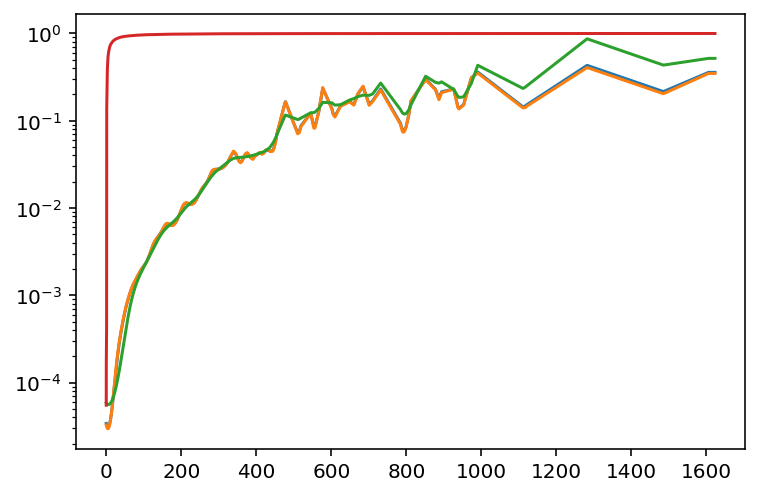

In [239]:
kde_density_1= stats.gaussian_kde(fire_size_arr, bw_method= "silverman")
kde_density_2= stats.gaussian_kde(fire_size_arr, bw_method= "scott")
kde_density_3= stats.gaussian_kde(fire_size_arr, bw_method= 0.3)

plt.plot(np.sort(y_sizes_train), 10**-6/kde_density_1.evaluate(np.sort(y_sizes_train)))
plt.plot(np.sort(y_sizes_train), 10**-6/kde_density_2.evaluate(np.sort(y_sizes_train)))
plt.plot(np.sort(y_sizes_train), 10**-6/kde_density_3.evaluate(np.sort(y_sizes_train)))
plt.plot(np.sort(y_sizes_train), empcdf_sizes.cdf(np.sort(y_sizes_train)).numpy())
plt.yscale('log')

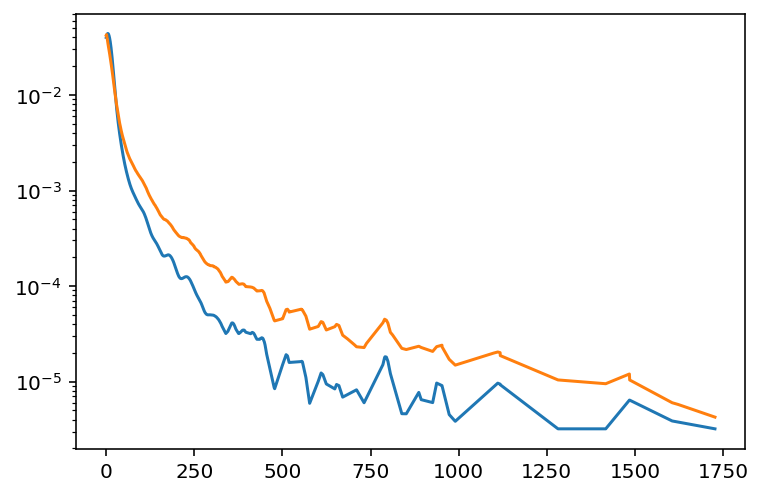

In [78]:
#plt.plot(np.sort(s), (1 - np.sort(cdf_emp_sizes)))
plt.plot(np.sort(y_sizes_train), (1/0.73)*kde_density.evaluate(np.sort(y_sizes_train)))
plt.plot(np.sort(fire_size_arr), (1/4)*sampling_func(y_sizes_train)(np.sort(fire_size_arr)))

plt.yscale('log')

## Fire size LOCO analysis

In [7]:
run_id= '22_01_28'
var_df= fire_size_loco(firefile= fire_file, reg_freq_df= reg_freq_df, res= '12km', n_iters= 50, n_epochs= 500, bs= 32, run_id= run_id)
var_df.to_hdf('../sav_files/loco_size_runs_%s/'%run_id + 'variables_size_loco_runs_%s.h5'%run_id, key= 'df', mode= 'w')

  0%|                                                    | 0/50 [00:00<?, ?it/s]2022-01-28 14:42:44.756682: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-28 14:42:44.756846: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Initialized a MDN with 2 layers and 8 neurons
MDN trained for 244 epochs


2022-01-28 14:43:28.395607: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_1_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 274 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_1_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 289 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_1_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 329 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_1_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 276 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_

/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 273 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_2_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 252 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_2_var_1/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 236 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_2_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 170 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_2_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 291 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_2_var_4/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 12 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_2_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 236 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_2_var_6/assets
Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 170 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_2_var_7/assets
Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_2_var_8/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 225 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_2_var_9/assets
Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 337 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_2_var_10/assets


  4%|█▌                                      | 2/50 [26:58<10:37:22, 796.71s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 215 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_3_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 261 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_3_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 261 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_3_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 333 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_3_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 369 epochs
INFO:tensorflow:A

  6%|██▍                                     | 3/50 [41:36<10:52:59, 833.60s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 395 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_4_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 296 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_4_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 322 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_4_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 296 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_4_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 348 epochs
INFO:tensorflow:A

  8%|███▏                                    | 4/50 [58:46<11:38:40, 911.32s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 13 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_5_var_0/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_5_var_1/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_5_var_2/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_5_var_3/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 11 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_5_var_4/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 188 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_5_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_5_var_6/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_5_var_7/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 170 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_5_var_8/assets
Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 165 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_5_var_9/assets
Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 11 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_5_var_10/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 244 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_6_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 177 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_6_var_1/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 157 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_6_var_2/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 318 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_6_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 245 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_6_var_4/assets
Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 332 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_6_var_5/assets
Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 212 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_6_var_6/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 347 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_6_var_7/assets
Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 336 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_6_var_8/assets
Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 313 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_6_var_9/assets
Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 229 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_6_var_10/assets


 12%|████▋                                  | 6/50 [1:20:26<9:33:19, 781.80s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 284 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_7_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 288 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_7_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 247 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_7_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 201 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_7_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 284 epochs
INFO:tensorflow:A

 14%|█████▍                                 | 7/50 [1:33:34<9:21:35, 783.61s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 171 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_8_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 417 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_8_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 347 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_8_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 270 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_8_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 267 epochs
INFO:tensorflow:A

 16%|██████▏                                | 8/50 [1:48:09<9:28:59, 812.84s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 486 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_9_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 217 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_9_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 262 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_9_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 149 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_9_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 313 epochs
INFO:tensorflow:A

 18%|███████                                | 9/50 [2:02:27<9:25:08, 827.03s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 491 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_10_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 234 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_10_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 234 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_10_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 191 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_10_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 351 epochs
INFO:tensorfl

 20%|███████▌                              | 10/50 [2:18:36<9:40:23, 870.58s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 257 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_11_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 257 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_11_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 337 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_11_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 306 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_11_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 319 epochs
INFO:tensorfl

 22%|████████▎                             | 11/50 [2:34:01<9:36:52, 887.49s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 201 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_12_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 181 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_12_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 181 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_12_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 205 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_12_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 277 epochs
INFO:tensorfl

 24%|█████████                             | 12/50 [2:46:00<8:49:35, 836.20s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_13_var_0/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_13_var_1/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_13_var_2/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_13_var_3/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_13_var_4/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_13_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_13_var_6/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_13_var_7/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_13_var_8/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_13_var_9/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_13_var_10/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 223 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_14_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 141 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_14_var_1/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 141 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_14_var_2/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 141 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_14_var_3/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 276 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_14_var_4/assets
Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 182 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_14_var_5/assets
Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 132 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_14_var_6/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 141 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_14_var_7/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 200 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_14_var_8/assets
Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 306 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_14_var_9/assets
Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 307 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_14_var_10/assets


 28%|██████████▋                           | 14/50 [3:03:51<6:59:47, 699.65s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_15_var_0/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_15_var_1/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_15_var_2/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_15_var_3/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_15_var_4/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_15_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_15_var_6/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_15_var_7/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_15_var_8/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_15_var_9/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_15_var_10/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 254 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_16_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 274 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_16_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 324 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_16_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 215 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_16_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 254 epochs
INFO:tensorfl

 32%|████████████▏                         | 16/50 [3:23:37<6:18:25, 667.80s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 274 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_17_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 263 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_17_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 274 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_17_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 318 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_17_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 274 epochs
INFO:tensorfl

 34%|████████████▉                         | 17/50 [3:38:13<6:41:49, 730.59s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 292 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_18_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 190 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_18_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 190 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_18_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 190 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_18_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 130 epochs
INFO:tensorfl

 36%|█████████████▋                        | 18/50 [3:49:53<6:24:35, 721.12s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 204 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_19_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 258 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_19_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 258 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_19_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 237 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_19_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 226 epochs
INFO:tensorfl

 38%|██████████████▍                       | 19/50 [4:03:50<6:30:36, 756.02s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 293 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_20_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 210 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_20_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 210 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_20_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 210 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_20_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 316 epochs
INFO:tensorfl

 40%|███████████████▏                      | 20/50 [4:19:06<6:41:58, 803.95s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 257 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_21_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 257 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_21_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 337 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_21_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 306 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_21_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 319 epochs
INFO:tensorfl

 42%|███████████████▉                      | 21/50 [4:34:26<6:45:24, 838.78s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 235 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_22_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 172 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_22_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 208 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_22_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 249 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_22_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 184 epochs
INFO:tensorfl

 44%|████████████████▋                     | 22/50 [4:46:59<6:19:29, 813.20s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 368 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_23_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 362 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_23_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 265 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_23_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 246 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_23_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 243 epochs
INFO:tensorfl

/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 256 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_24_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 199 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_24_var_1/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 178 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_24_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 186 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_24_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 302 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_24_var_4/assets
Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 219 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_24_var_5/assets
Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 8 

/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 244 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_24_var_7/assets
Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 186 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_24_var_8/assets
Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 302 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_24_var_9/assets
Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 256 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_24_var_10/assets


 48%|██████████████████▏                   | 24/50 [5:15:02<5:57:07, 824.12s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 11 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_25_var_0/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 338 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_25_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 338 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_25_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_25_var_3/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 11 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_25_var_4/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_25_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 395 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_25_var_6/assets
Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_25_var_7/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 388 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_25_var_8/assets
Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 329 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_25_var_9/assets
Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 11 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_25_var_10/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 337 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_26_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 237 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_26_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 237 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_26_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 237 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_26_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 236 epochs
INFO:tensorfl

 52%|███████████████████▊                  | 26/50 [5:40:14<5:18:59, 797.46s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 248 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_27_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 284 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_27_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 389 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_27_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 283 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_27_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 283 epochs
INFO:tensorfl

 54%|████████████████████▌                 | 27/50 [5:55:54<5:22:04, 840.20s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 13 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_28_var_0/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_28_var_1/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_28_var_2/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_28_var_3/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 11 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_28_var_4/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 188 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_28_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_28_var_6/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_28_var_7/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 170 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_28_var_8/assets
Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 165 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_28_var_9/assets
Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 11 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_28_var_10/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 10 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_29_var_0/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 290 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_29_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 318 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_29_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 318 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_29_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 23 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_29_var_4/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 293 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_29_var_5/assets
Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 284 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_29_var_6/assets
Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 268 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_29_var_7/assets
Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 237 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_29_var_8/assets
Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers 

/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 224 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_30_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 427 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_30_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 335 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_30_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 321 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_30_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 205 epochs
INFO:tensorfl

 60%|██████████████████████▊               | 30/50 [6:30:39<4:19:48, 779.44s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 337 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_31_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 352 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_31_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 500 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_31_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 21 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_31_var_3/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 262 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_31_var_4/assets
Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 21 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_31_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 235 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_31_var_6/assets
Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 21 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_31_var_7/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 26 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_31_var_8/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 298 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_31_var_9/assets
Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 441 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_31_var_10/assets


 62%|███████████████████████▌              | 31/50 [6:43:40<4:06:54, 779.74s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 241 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_32_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 265 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_32_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 288 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_32_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 389 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_32_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 265 epochs
INFO:tensorfl

 64%|████████████████████████▎             | 32/50 [6:58:29<4:03:45, 812.52s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 204 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_33_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 258 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_33_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 258 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_33_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 237 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_33_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 226 epochs
INFO:tensorfl

 66%|█████████████████████████             | 33/50 [7:12:18<3:51:37, 817.51s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 251 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_34_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 313 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_34_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 190 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_34_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 365 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_34_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 251 epochs
INFO:tensorfl

 68%|█████████████████████████▊            | 34/50 [7:27:39<3:46:16, 848.54s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 167 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_35_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 500 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_35_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 264 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_35_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 317 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_35_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 166 epochs
INFO:tensorfl

 70%|██████████████████████████▌           | 35/50 [7:42:16<3:34:14, 856.99s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 171 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_36_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 417 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_36_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 347 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_36_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 270 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_36_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 267 epochs
INFO:tensorfl

 72%|███████████████████████████▎          | 36/50 [7:57:11<3:22:38, 868.47s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 292 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_37_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 190 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_37_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 190 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_37_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 190 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_37_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 130 epochs
INFO:tensorfl

 74%|████████████████████████████          | 37/50 [8:09:03<2:58:00, 821.58s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 243 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_38_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 227 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_38_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 195 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_38_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 193 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_38_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 201 epochs
INFO:tensorfl

 76%|████████████████████████████▉         | 38/50 [8:22:26<2:43:11, 815.94s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 252 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_39_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 244 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_39_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 282 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_39_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 15 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_39_var_3/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 294 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_39_var_4/assets
Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 282 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_39_var_5/assets
Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 303 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_39_var_6/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 15 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_39_var_7/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 282 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_39_var_8/assets
Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 255 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_39_var_9/assets
Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 228 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_39_var_10/assets


 78%|█████████████████████████████▋        | 39/50 [8:35:27<2:27:39, 805.43s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 303 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_40_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 327 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_40_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 282 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_40_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 14 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_40_var_3/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 203 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_40_var_4/assets
Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 14 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_40_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 14 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_40_var_6/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 14 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_40_var_7/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 14 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_40_var_8/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 252 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_40_var_9/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 500 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_40_var_10/assets


 80%|██████████████████████████████▍       | 40/50 [8:46:52<2:08:14, 769.43s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 220 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_41_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 213 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_41_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 478 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_41_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 183 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_41_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 220 epochs
INFO:tensorfl

 82%|███████████████████████████████▏      | 41/50 [9:02:01<2:01:42, 811.37s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 233 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_42_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 255 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_42_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 230 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_42_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 231 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_42_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 237 epochs
INFO:tensorfl

 84%|███████████████████████████████▉      | 42/50 [9:15:35<1:48:16, 812.04s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 238 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_43_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 196 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_43_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 194 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_43_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 238 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_43_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 265 epochs
INFO:tensorfl

 86%|████████████████████████████████▋     | 43/50 [9:29:06<1:34:43, 811.88s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 256 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_44_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 231 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_44_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 233 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_44_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 231 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_44_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 327 epochs
INFO:tensorfl

 88%|█████████████████████████████████▍    | 44/50 [9:43:08<1:22:05, 820.89s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 256 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_45_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 231 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_45_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 233 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_45_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 231 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_45_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 327 epochs
INFO:tensorfl

 90%|██████████████████████████████████▏   | 45/50 [9:57:04<1:08:46, 825.34s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 171 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_46_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 417 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_46_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 347 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_46_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 270 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_46_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 267 epochs
INFO:tensorfl

 92%|███████████████████████████████████▉   | 46/50 [10:12:00<56:25, 846.48s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 491 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_47_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 234 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_47_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 234 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_47_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 191 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_47_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 351 epochs
INFO:tensorfl

 94%|████████████████████████████████████▋  | 47/50 [10:28:41<44:38, 892.79s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 286 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_48_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 336 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_48_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 214 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_48_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 378 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_48_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 207 epochs
INFO:tensorfl

/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 279 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_48_var_6/assets
Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 395 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_48_var_7/assets
Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 212 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_48_var_8/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 197 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_48_var_9/assets
Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 312 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_48_var_10/assets


 96%|█████████████████████████████████████▍ | 48/50 [10:43:27<29:41, 890.71s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 193 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_49_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 201 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_49_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 276 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_49_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 201 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_49_var_3/assets
Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 229 epochs
INFO:tensorfl

 98%|██████████████████████████████████████▏| 49/50 [10:57:24<14:34, 874.71s/it]

Initialized a MDN with 2 layers and 8 neurons
MDN trained for 303 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_50_var_0/assets
Loading predictor variable data without VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 327 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_50_var_1/assets
Loading predictor variable data without Tmax
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 282 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_50_var_2/assets
Loading predictor variable data without Forest
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 14 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_50_var_3/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Urban
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 203 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_50_var_4/assets
Loading predictor variable data without FM1000
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 14 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_50_var_5/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Prec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 14 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_50_var_6/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Antprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 14 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_50_var_7/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Ant_VPD
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 14 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_50_var_8/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without Avgprec
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 252 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_50_var_9/assets


/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/hyfives-lamont/miniforge3/lib/python3.9/s

Loading predictor variable data without FFWI
Initialized a MDN with 2 layers and 8 neurons
MDN trained for 500 epochs
INFO:tensorflow:Assets written to: ../sav_files/loco_size_runs_22_01_28/mdn_12km_gpd_iter_run_50_var_10/assets


100%|███████████████████████████████████████| 50/50 [11:09:08<00:00, 802.97s/it]


In [11]:
n_regions= 18
reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", 15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}
varlist= np.array(['All', 'VPD', 'Tmax', 'Forest', 'Urban', 'FM1000'])

In [12]:
run_id= '22_01_27'
var_df= pd.read_hdf('../sav_files/loco_size_runs_%s'%run_id + '/variables_size_loco_runs_%s.h5'%run_id)

In [37]:
reg_loss_arr= []
reg_argind= [] #.sort_values(by= ["Loss"], ascending= False).iloc[[0]]
for r in tqdm(range(n_regions)):
    reg_loss= np.asarray([var_df.groupby('reg_indx').get_group(r+1).groupby('Variable').get_group(v).sort_values(by= ["Loss"]).iloc[[0]]['Loss'] \
                                                                for v in range(len(varlist))]).flatten()
    reg_argind.append(np.argsort(abs(reg_loss - reg_loss[0])/reg_loss[0])[1:])
    reg_loss_arr.append(np.sort(abs(reg_loss - reg_loss[0])/reg_loss[0])[1:])

100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 138.29it/s]


In [80]:
var_df.groupby('Iteration').get_group(28).groupby('reg_indx').get_group(8).sort_values(by=["Loss"], ascending= False).dropna()

,Iteration,Variable,reg_indx,Pearson_r,Emp_Accuracy,Mod_Accuracy,Loss
2977,28,3,8,0.613147,97.217179,54.310120,4.545679
2923,28,0,8,0.526209,97.296789,57.432701,4.433491
3013,28,5,8,0.554400,97.341993,61.836975,4.348647
2995,28,4,8,0.490348,97.452610,60.475075,4.318840
2959,28,2,8,0.592903,97.459154,59.876366,4.280407
2941,28,1,8,0.612683,97.575334,59.973370,4.244106


In [95]:
var_df.groupby('reg_indx').get_group(1).groupby('Iteration').get_group(8).sort_values(by= ["Loss"], ascending= False)

,Iteration,Variable,reg_indx,Pearson_r,Emp_Accuracy,Mod_Accuracy,Loss
774,8,1,1,0.648784,97.322220,72.639618,4.148787
792,8,2,1,0.560872,97.464638,75.771088,4.025559
810,8,3,1,0.626891,97.598151,77.390388,3.940776
756,8,0,1,0.519324,97.537460,80.048119,3.936488
828,8,4,1,0.573483,97.519024,79.605652,3.928916
846,8,5,1,0.647946,97.640383,77.503227,3.877088


In [56]:
np.asarray([var_df.groupby('reg_indx').get_group(8).groupby('Variable').get_group(v).sort_values(by= ["Emp_Accuracy"], ascending= False).iloc[[0]]['Emp_Accuracy'] \
                                                                for v in range(len(varlist))]).flatten()

array([97.58167839, 97.59054995, 97.59447384, 97.6452167 , 97.65708256,
       97.65451574])

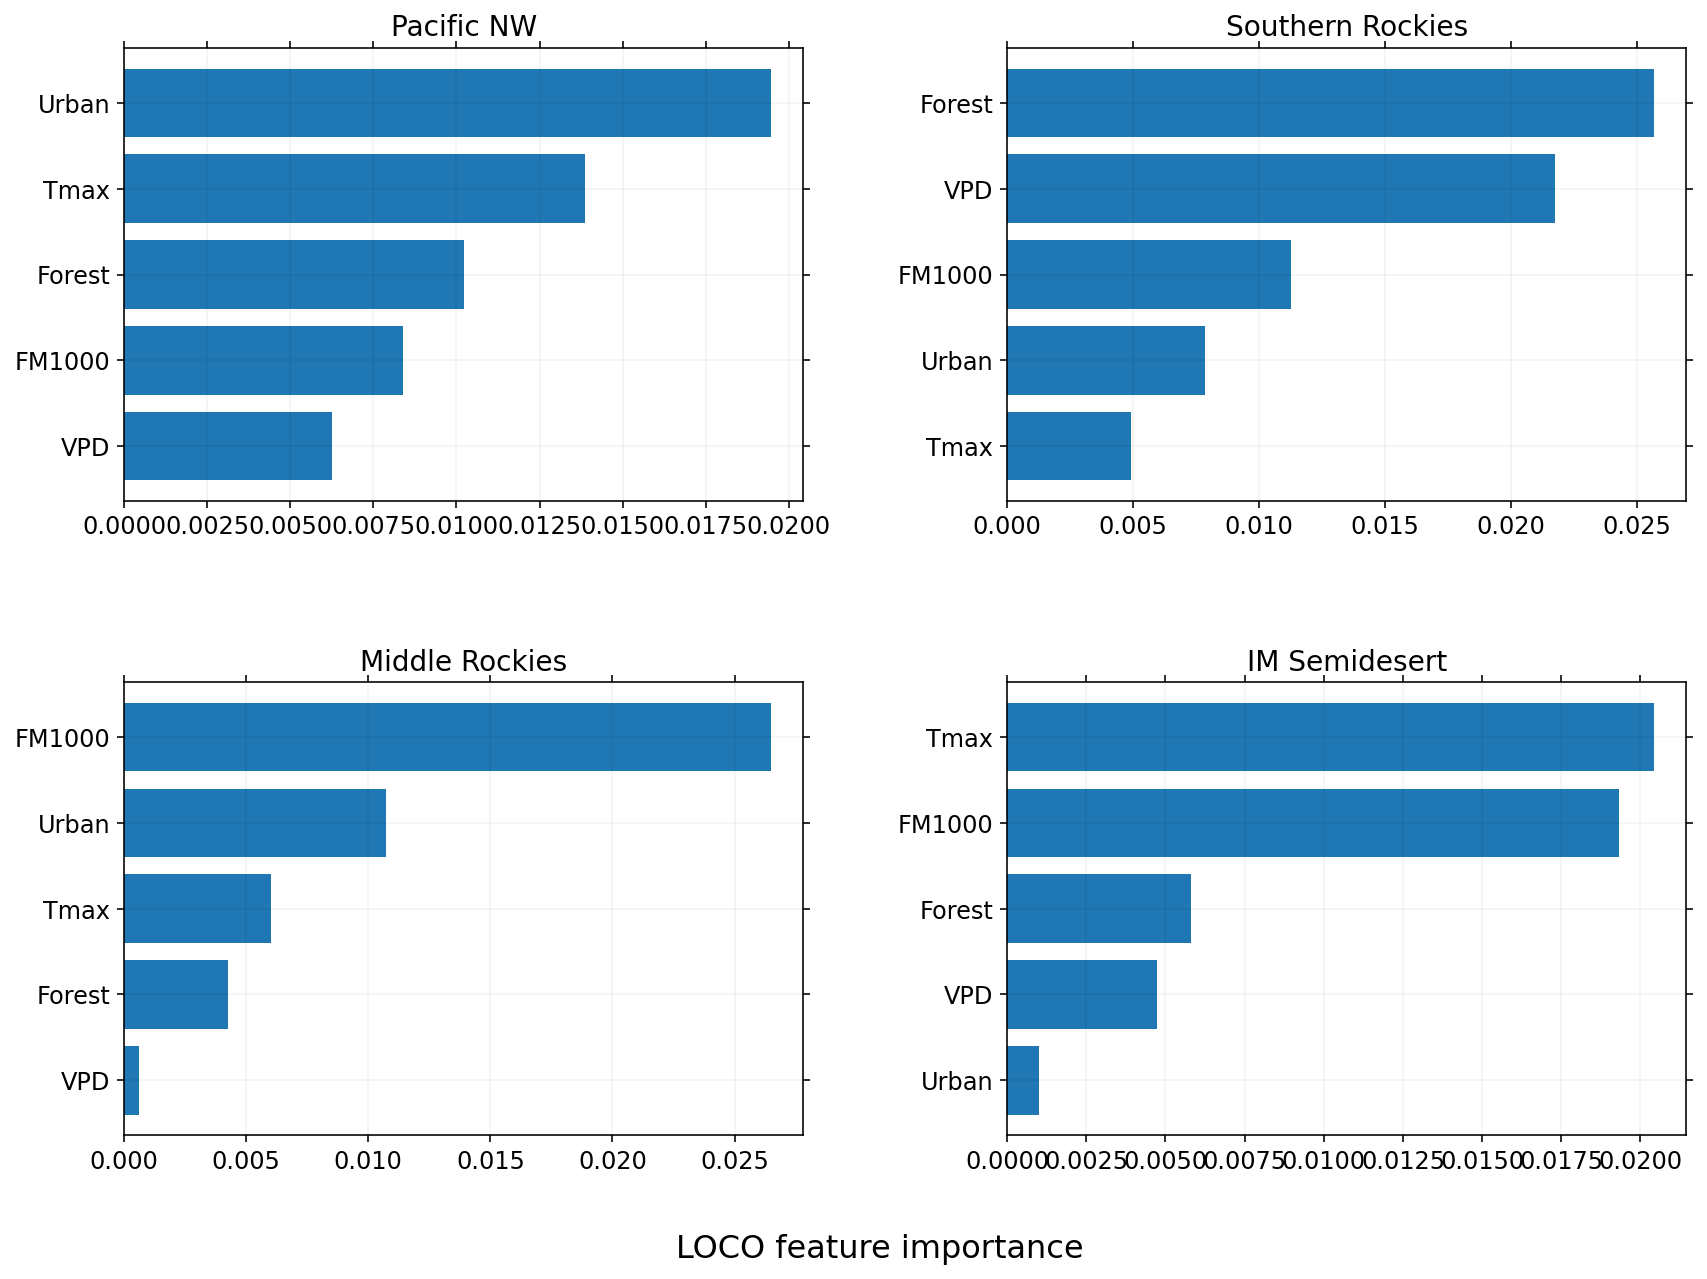

In [38]:
loco_grid= [[[1, 2], [3, 4]], [[5, 9], [8, 12]]] 

fig, ax= plt.subplots(2, 2, figsize=(14, 10))
#plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
#fig.text(0.04, 0.5, r'', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'LOCO feature importance', ha='center', fontsize= 16)

for i in range(2):
    for j in range(2):
        regindx= loco_grid[1][i][j]
        
        ax[i, j].barh(varlist[reg_argind[regindx - 1]], reg_loss_arr[regindx - 1]);
        ax[i, j].set_title(reg_name[regindx], fontsize= 14);
            
        fig.subplots_adjust(hspace= 0.4, wspace= 0.3)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/loco_fire_size_1.pdf', bbox_inches='tight');

In [39]:
tot_avg_loss= np.asarray([np.mean([var_df.groupby('reg_indx').get_group(r+1).groupby('Variable').get_group(v).sort_values(by= ["Loss"]).iloc[[0]]['Loss'] \
                                                                   for r in range(n_regions)]) for v in range(len(varlist))])
tot_argind= np.argsort(abs(tot_avg_loss - tot_avg_loss[0]))

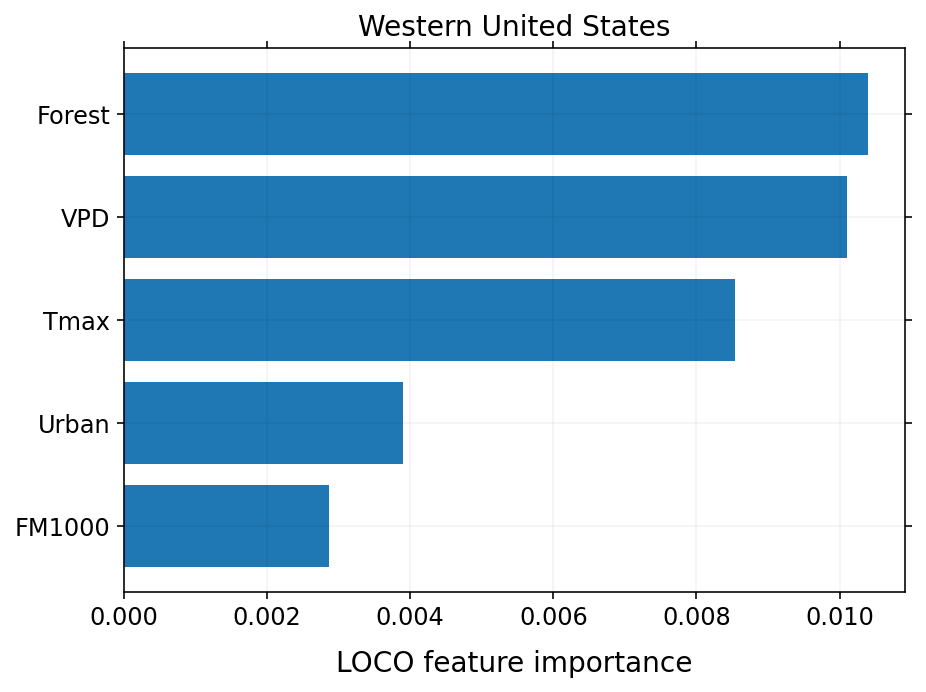

In [40]:
fig, ax= plt.subplots(1, 1, figsize=(7, 5))
ax.barh(varlist[tot_argind][1:], np.sort(abs(tot_avg_loss - tot_avg_loss[0])/tot_avg_loss[0])[1:]);
ax.set_title(r'Western United States', fontsize= 14);
ax.set_xlabel(r'LOCO feature importance', ha='center', fontsize= 14, labelpad= 10)
fig.subplots_adjust(hspace= 0.4, wspace= 0.3)
#fig.minorticks_on()
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
ax.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/loco_fire_size_all.pdf', bbox_inches='tight');